
# SET50 Model Comparison (LSTM vs Transformer) — **Leakage‑Free, Val/EarlyStopping, Correct Target**
**Author:** Patchara (Pae) & ChatGPT (Senior AI Engineer)  
**What’s fixed:**  
- ✅ Fit `MinMaxScaler` **only on train** (no leakage)  
- ✅ Use dynamic `target_idx = df.columns.get_loc('Close')` (no hard‑coded index)  
- ✅ Correct pooling (`GlobalAveragePooling1D()`; channels_last)  
- ✅ Add validation split, `EarlyStopping`, and `ReduceLROnPlateau`  
- ✅ Time-series‑friendly split (val from the tail of train windows)  
- ✅ Results table (RMSE, MAE, Directional Accuracy) + Plot  

> **Tip:** Run on **Google Colab** (GPU optional). If using Colab, consider mounting Drive to save models.


In [1]:

# --- PART 1: SETUP AND IMPORTS ---
print(">>> PART 1: Setting up environment...")
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, LSTM)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def set_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

set_seeds(42)

print("TensorFlow:", tf.__version__)


>>> PART 1: Setting up environment...
TensorFlow: 2.19.0


In [5]:

# --- OPTIONAL: Colab Drive Mount ---
from google.colab import drive
drive.mount('/content/drive')
SAVE_DIR = " /content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/01_notebooks"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/01_notebooks"
os.makedirs(SAVE_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

# --- PART 2: DATA PREPARATION (Leakage-free) ---
print("\n>>> PART 2: Preparing data...")

# If running locally in ChatGPT sandbox, this path exists. In Colab, upload the same CSV or change path.
data_path = "/content/drive/MyDrive/Colab Notebooks/Thai_Quant_AI_Project/02_data/set50_processed_data.csv"  # change to your path if needed
df = pd.read_csv(data_path, parse_dates=['Date'])
df = df.sort_values('Date').set_index('Date')

# Pick target column dynamically
target_col = 'Close'
assert target_col in df.columns, f"'{target_col}' not in columns: {list(df.columns)}"
target_idx = df.columns.get_loc(target_col)

display(df.head(3))
print("Rows:", len(df), "| Cols:", len(df.columns), "| target_idx:", target_idx)



>>> PART 2: Preparing data...


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
Date,,,,,,,,,,,,,,,,
2015-10-08 00:00:00+07:00,1393.790039,1401.839966,1390.000000,1392.150024,12575600,0.0,0.0,63.249715,2.720300,2.813736,-0.093436,1337.365024,1373.204004,1409.042983,5.219760,0.764321
2015-10-09 00:00:00+07:00,1404.680054,1415.530029,1403.540039,1411.329956,11022700,0.0,0.0,69.072472,5.714967,4.646723,1.068245,1351.634001,1386.200000,1420.765999,4.987159,0.863507
2015-10-12 00:00:00+07:00,1415.439941,1417.510010,1406.609985,1412.489990,10683500,0.0,0.0,69.388381,8.088627,5.616306,2.472321,1365.498601,1396.063989,1426.629377,4.378795,0.768703


Rows: 2392 | Cols: 16 | target_idx: 3


In [7]:

train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].copy()
df_test  = df.iloc[train_size:].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)   # fit only on train
test_scaled  = scaler.transform(df_test)

time_step = 60

def create_dataset(dataset, time_step, target_idx):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, target_idx])
    return np.array(X), np.array(y)

# For test, prepend tail of train to ensure enough history
test_stacked = np.vstack([train_scaled[-time_step:], test_scaled])

X_train_full, y_train_full = create_dataset(train_scaled, time_step, target_idx)
X_test, y_test = create_dataset(test_stacked, time_step, target_idx)

# Time-series friendly validation from the tail of train windows
val_frac = 0.15
val_len = max(1, int(len(X_train_full) * val_frac))
X_train, y_train = X_train_full[:-val_len], y_train_full[:-val_len]
X_val, y_val     = X_train_full[-val_len:], y_train_full[-val_len:]

print("Train windows:", X_train.shape, "| Val windows:", X_val.shape, "| Test windows:", X_test.shape)


Train windows: (1575, 60, 16) | Val windows: (277, 60, 16) | Test windows: (478, 60, 16)


In [8]:

# --- PART 3: LSTM Baseline ---
def build_lstm_model(input_shape, hidden=64, dropout=0.2):
    inputs = Input(shape=input_shape)
    x = LSTM(hidden, return_sequences=False)(inputs)
    x = Dropout(dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

lstm_model = build_lstm_model(X_train.shape[1:], hidden=64, dropout=0.2)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

print("Training LSTM... (this may take a few minutes)")
hist_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=64, verbose=1, callbacks=callbacks
)

# Optional: save model
lstm_path = os.path.join(SAVE_DIR, "lstm_benchmark_model.h5")
lstm_model.save(lstm_path)
print("Saved:", lstm_path)


Training LSTM... (this may take a few minutes)
Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.1050 - val_loss: 6.3323e-04 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0188 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0135 - val_loss: 4.7817e-04 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0122 - val_loss: 8.4560e-04 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0099 - val_loss: 3.6753e-04 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0092 - val_loss: 6.9662e-04 - learning_rate: 0.0010
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0089 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0077 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step -

Saved: .01_notebooks/lstm_benchmark_model.h5


In [9]:

# --- PART 4: Transformer (Corrected) ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    # Self-attention + residual
    attn_out = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(attn_out)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    # Feed-forward + residual
    ffn_in = x
    ffn = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1])  # project back to feature dim
    ])
    x = ffn(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(ffn_in + x)
    return x

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128,
                            num_transformer_blocks=3, mlp_units=[128], dropout=0.2, mlp_dropout=0.3):
    inputs = Input(shape=input_shape)  # (time, features)

    # Learnable positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embedding = tf.keras.layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embedding  # broadcast add

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Correct pooling for (batch, time, features)
    x = GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

tr_model = build_transformer_model(X_train.shape[1:], head_size=64, num_heads=4, ff_dim=128,
                                   num_transformer_blocks=3, mlp_units=[128], dropout=0.2, mlp_dropout=0.3)
tr_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

print("Training Transformer... (this may take a few minutes)")
hist_tr = tr_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200, batch_size=64, verbose=1, callbacks=callbacks
)

tr_path = os.path.join(SAVE_DIR, "transformer_upgrade_model.h5")
tr_model.save(tr_path)
print("Saved:", tr_path)


Training Transformer... (this may take a few minutes)
Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - loss: 0.1866 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - loss: 0.0386 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0258 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - loss: 0.0163 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - loss: 0.0130 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - loss: 0.0113 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - loss: 0.0110 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step - loss: 0.0106 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step

Saved: .01_notebooks/transformer_upgrade_model.h5


len(actual) = 478
len(lstm)   = 478
len(trans)  = 478
\n--- Performance Comparison ---
                   Model  RMSE (Baht)  MAE (Baht)  Directional Acc.  \
0       LSTM (Benchmark)    24.716224   20.198448          0.534591   
1  Transformer (Upgrade)    96.518762   68.302868          0.494759   

  Δ Error vs LSTM (%)  
0                   -  
1            +290.51%  


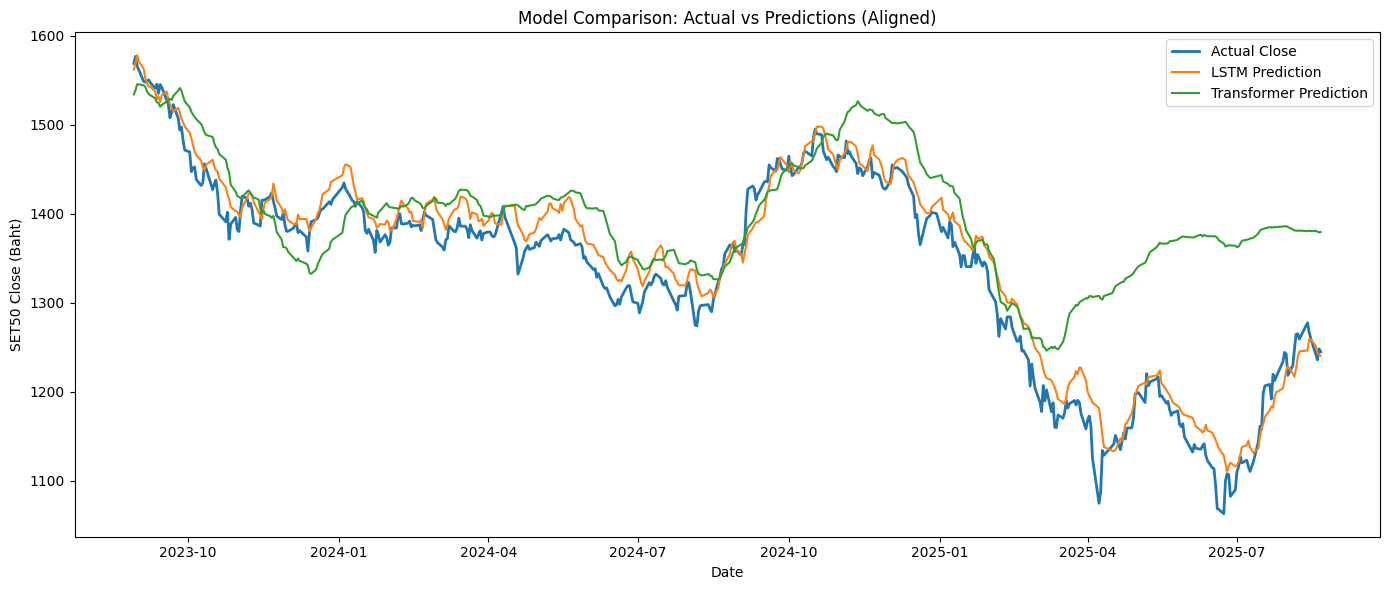

In [11]:

# --- PART 5: Evaluation & Comparison (fixed alignment) ---

def inverse_transform_predictions(predictions, scaler, n_features, target_idx):
    tmp = np.zeros((len(predictions), n_features))
    tmp[:, target_idx] = predictions.flatten()
    inv = scaler.inverse_transform(tmp)[:, target_idx]
    return inv

# 1) พยากรณ์ (บน X_test)
lstm_pred = lstm_model.predict(X_test, verbose=0)
tr_pred   = tr_model.predict(X_test, verbose=0)

# 2) แปลงกลับเป็นบาท
lstm_pred_inv = inverse_transform_predictions(lstm_pred, scaler, df.shape[1], target_idx)
tr_pred_inv   = inverse_transform_predictions(tr_pred,   scaler, df.shape[1], target_idx)

# 3) หา actual ให้ “ยาวเท่ากัน” ด้วยวิธีเดียวกับ y_test แต่ใช้ข้อมูลดิบ (ไม่สเกล)
raw_train = df_train.values
raw_test  = df_test.values
raw_test_stacked = np.vstack([raw_train[-time_step:], raw_test])

_, actual_prices = create_dataset(raw_test_stacked, time_step, target_idx)  # <-- ได้ยาวเท่ากับ X_test

# 4) วันที่ให้สอดคล้องกับ actual (คือ index ของ df_test ตั้งแต่แถวแรก ไปตามจำนวน actual)
test_dates = df_test.index[:len(actual_prices)]

# 5) ตรวจความยาวให้ชัวร์
print("len(actual) =", len(actual_prices))
print("len(lstm)   =", len(lstm_pred_inv))
print("len(trans)  =", len(tr_pred_inv))

# ---- Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def mae(y, yhat):  return float(mean_absolute_error(y, yhat))
def dir_acc(y, yhat):
    dy  = np.sign(np.diff(y))
    dyh = np.sign(np.diff(yhat))
    return float((dy == dyh).mean()) if len(dy)==len(dyh) and len(dy)>0 else np.nan

metrics = pd.DataFrame([
    {"Model": "LSTM (Benchmark)",
     "RMSE (Baht)": rmse(actual_prices, lstm_pred_inv),
     "MAE (Baht)":  mae(actual_prices, lstm_pred_inv),
     "Directional Acc.": dir_acc(actual_prices, lstm_pred_inv)},
    {"Model": "Transformer (Upgrade)",
     "RMSE (Baht)": rmse(actual_prices, tr_pred_inv),
     "MAE (Baht)":  mae(actual_prices, tr_pred_inv),
     "Directional Acc.": dir_acc(actual_prices, tr_pred_inv)},
])

delta_rmse = (metrics.loc[1, "RMSE (Baht)"] - metrics.loc[0, "RMSE (Baht)"]) / metrics.loc[0, "RMSE (Baht)"] * 100
metrics["Δ Error vs LSTM (%)"] = ["-", f"{delta_rmse:+.2f}%"]
print("\\n--- Performance Comparison ---")
print(metrics)

# ---- Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(test_dates, actual_prices, label="Actual Close", linewidth=2)
plt.plot(test_dates, lstm_pred_inv, label="LSTM Prediction")
plt.plot(test_dates, tr_pred_inv, label="Transformer Prediction")
plt.title("Model Comparison: Actual vs Predictions (Aligned)")
plt.xlabel("Date"); plt.ylabel("SET50 Close (Baht)")
plt.legend(); plt.tight_layout(); plt.show()


In [12]:

# --- PART 6: Save results (optional) ---
metrics_path = os.path.join(SAVE_DIR, "model_comparison_metrics.csv")
pd.DataFrame(metrics).to_csv(metrics_path, index=False)
print("Saved metrics to:", metrics_path)


Saved metrics to: .01_notebooks/model_comparison_metrics.csv
